In [1]:
import torch
import torch.nn as nn

## Intersección sobre la unión

Empezaremos definiendo la función auxiliar para calcular IoU, ya que la usaremos en distintas etapas del desarrollo.

La lógica de la función puede derivarse de la siguiente imagen de referencia

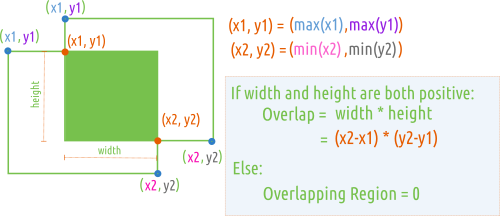

In [2]:
def intersection_over_union(
    pred_boxes: torch.Tensor,
    true_boxes: torch.Tensor
) -> torch.Tensor:
    """
    Calcula la intersección sobre la unión (IoU) entre las bounding boxes predichas y las verdaderas
    Las formas de los tensores deben ser [..., 4], en formato (x,y,w,h)
    """

    # Convierto coordenadas de (x, y, w, h) a (x1, x2, y1, y2)
    box1_x1 = pred_boxes[..., 0:1] - pred_boxes[..., 2:3] / 2
    box1_y1 = pred_boxes[..., 1:2] - pred_boxes[..., 3:4] / 2
    box1_x2 = pred_boxes[..., 0:1] + pred_boxes[..., 2:3] / 2
    box1_y2 = pred_boxes[..., 1:2] + pred_boxes[..., 3:4] / 2
    box2_x1 = true_boxes[..., 0:1] - true_boxes[..., 2:3] / 2
    box2_y1 = true_boxes[..., 1:2] - true_boxes[..., 3:4] / 2
    box2_x2 = true_boxes[..., 0:1] + true_boxes[..., 2:3] / 2
    box2_y2 = true_boxes[..., 1:2] + true_boxes[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Si no hay intersección entre las bboxes, las restas pueden ser < 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection)

In [3]:
# Ejemplo de prueba para probar la función:
"""
Dos bboxes con el mismo centro y mismo ancho, pero una con el doble de alto que la otra.
IoU debería ser 0.5
"""
bbox1 = torch.tensor([[0.5, 0.5, 0.1, 0.1]])
bbox2 = torch.tensor([[0.5, 0.5, 0.1, 0.2]])
intersection_over_union(bbox1, bbox2)

tensor([[0.5000]])

In [4]:
# Ejemplo de prueba para probar la función:
"""
Dos bboxes de las mismas dimensiones, pero separadas de tal forma que no hay superposición.
IoU debería ser 0
"""
bbox1 = torch.tensor([[0.6, 0.5, 0.1, 0.1]])
bbox2 = torch.tensor([[0.4, 0.5, 0.1, 0.1]])
intersection_over_union(bbox1, bbox2)

tensor([[0.]])

# YOLOv1

## Arquitectura
Implementación basada en https://github.com/aladdinpersson/Machine-Learning-Collection

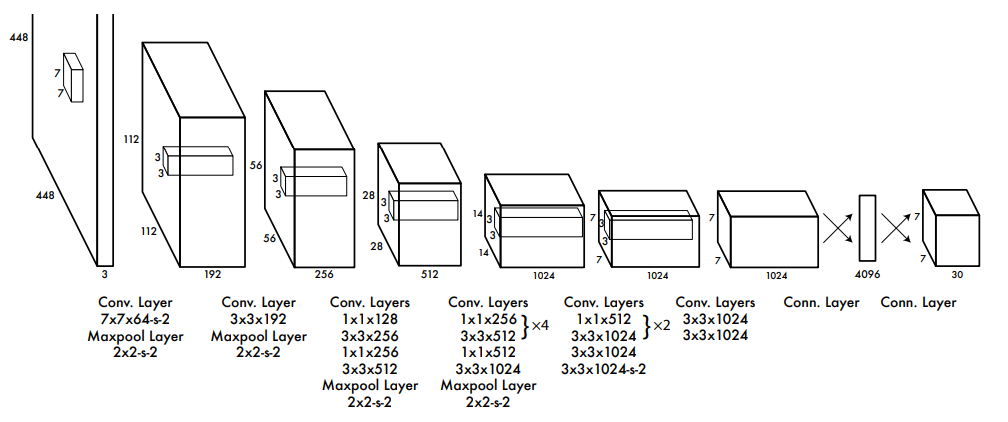

Comenzamos describiendo la arquitectura del backbone convolucional según el paper

In [5]:
architecture_config = [
    (7, 64, 2, 3),  # kernel_size, filters, stride, padding
    "M",  # MaxPooling, 2x2 stride=2
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],  # 2 capas convolucionales, repetidas 4 veces
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

Definimos un bloque convolucional con activación leaky relu siguiendo el paper. Agregamos una capa de BatchNormalization (no utilizada en la primera versión de YOLO) para acelerar el entrenamiento.

In [6]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

Usamos el bloque convolucional para armar toda la red. Cabe aclarar que el backbone de la red puede ser reemplazada por cualquier otro backbone convolucional, ya que lo que genera el volumen de salida con las predicciones de las bboxes es la etapa fully connected que le sigue.

In [7]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.conv_layers = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        """Definición de pasada forward. Input -> conv_layers -> fully connected"""
        x = self.conv_layers(x)
        return self.fcs(torch.flatten(x, start_dim=1)) # No aplano la dimensión del batch

    def _create_conv_layers(self, architecture):
        """Creación de capas convolucionales"""
        # Inicializo una lista vaía para ir agregando las capas convolucionales
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            # Las capas que agregaremos dependen del tipo de elemento de la lista
            if type(x) == tuple:
                # Agrego un bloque convolucional
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                # Los in_channels de la próxima capa, son los out_channels de la capa actual
                in_channels = x[1] 

            elif type(x) == str:
                # Agrego MaxPooling
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                # Agrego varios bloques convolucionales que se repiten
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1], # Los in_channels del 2ndo bloque son los out_channels del primero
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    # Los in_channels de la próxima capa, son los out_channels de la capa actual
                    in_channels = conv2[1]
        
        # Creo un modelo secuencial con la lista de capas convolucionales
        return nn.Sequential(*layers)

    def _create_fcs(
        self, 
        split_size, # Tamaño de la grilla, S
        num_boxes, # Cantidad de bboxes por celda
        num_classes, # Cantidad de clases
        dropout=0.5, 
        fc_hidden_layer=4096):
        """Definición de la etapa fully connected"""
        S, B, C = split_size, num_boxes, num_classes
        
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, fc_hidden_layer),
            nn.Dropout(dropout),
            nn.LeakyReLU(0.1),
            nn.Linear(fc_hidden_layer, S * S * (C + B * 5)) # Después se hace un reshape a [S, S, (C + B * 5)]
        )

In [8]:
model = Yolov1(
    in_channels=3,
    split_size=7,
    num_boxes=2,
    num_classes=20,
)

Tensor de prueba:

In [9]:
x = torch.randn((
    10, # Tamaño del batch
    3, # Cantidad de canales
    448, # Alto de la "imagen"
    448 # Ancho de la "imagen"
))
y = model(x)

In [10]:
y.shape

torch.Size([10, 1470])

In [11]:
7*7*(5*2+20)

1470

## Función de costo
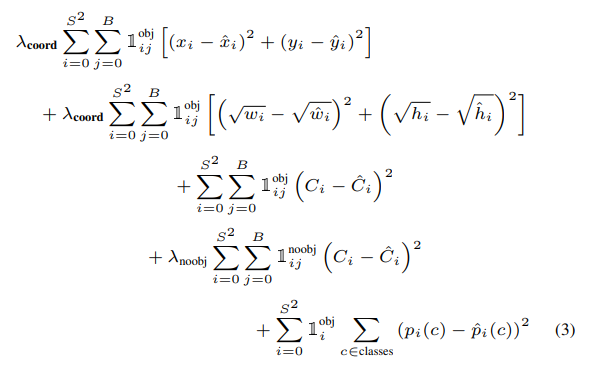

In [12]:
class YoloLoss(nn.Module):
    """
    Función de costo para YOLOv1
    """

    def __init__(self, 
                 # Definición del volumen de salida
                 S=7, B=2, C=20, 
                 # Definición de los factores de escala
                 lambda_noobj=0.5, lambda_coord=5
                ):
        
        super(YoloLoss, self).__init__()
        # Todas las componentes de la función de costo son errores cuadráticos
        self.mse = nn.MSELoss(reduction="sum") 

        self.S = S
        self.B = B
        self.C = C
        self.lambda_noobj = lambda_noobj
        self.lambda_coord = lambda_coord

    def forward(self, predictions, target):
        """
        Pasada forward del cálculo de la función de costo.
        La salida del modelo (predictions) es de forma (BATCH_SIZE, S*S(C+B*5). 
            La última dimensión es [c0..cC, p1, x1, y1, w1, h1, p2, x2, y2, w2, h2]
        El target es de forma (BATCH_SIZE, S, S, C+5). 
            La última dimensión es [c0..cC, Obj, x, y, w, h]
        """
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculamos IoU entre las 2 bboxes y el target para cada celda
        iou_b1 = intersection_over_union(
            predictions[..., self.C+1:self.C+5], 
            target[..., self.C+1:self.C+5]
        )
        iou_b2 = intersection_over_union(
            predictions[..., self.C+6:self.C+10], 
            target[..., self.C+1:self.C+5]
        )
        
        # Unimos las IoUs en un único tensor para calcular el máximo
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        # Nos quedamos con la bbox con mejor iou (la 0 o la 1)
        iou_maxes, bestbox = torch.max(ious, dim=0)
        
        Iobj_i = target[..., self.C].unsqueeze(3) 

        # ======================== #
        # Pérdida de localización  #
        # ======================== #

        # Las predicciones que tenemos que comparar con el target son:
        # - Aquellas en las que hay un objeto en la celda
        # - Las que tienen mejor IoU con el target (bestbox)
        box_predictions = Iobj_i * (
            (
                bestbox * predictions[..., self.C+6:self.C+10] # bestbox = 1
                + (1 - bestbox) * predictions[..., self.C+1:self.C+5] # bestbox = 0
            )
        )
        # Sólo nos interesa el target si hay un objeto en esa celda
        box_targets = Iobj_i * target[..., self.C+1:self.C+5]

        # En box_predictions y box_targets tenemos tensores de la forma
        # [batch_size, S, S, 4], donde la última dimensión es x, y, w, h
        
        # Calculamos la raiz de w y h, contemplando que los valores predichos pueden ser negativos
        # ya que la inicialización es random
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        # En el caso del target, eso no puede ocurrir
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        # Calculamos la pérdida de localización.
        # Cada celda de cada imagen del batch tiene su propia pérdida, así que aplanamos el tensor
        # [batch_size, S, S, 4] -> [batch_size * S * S, 4]
        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        # Pérdida de detección #
        # ==================== #

        # Me quedo con el confidence score de la bbox responsable por la detección
        conf_score = (
            bestbox * predictions[..., self.C+5:self.C+6] + \
            (1 - bestbox) * predictions[..., self.C:self.C+1]
        )
        # Calculo el error cuadrático con el target
        object_loss = self.mse(
            torch.flatten(Iobj_i * conf_score),
            torch.flatten(Iobj_i * target[..., self.C:self.C+1]),
        )

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - Iobj_i) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - Iobj_i) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - Iobj_i) * predictions[..., self.C:self.C+1], start_dim=-2),
            torch.flatten((1 - Iobj_i) * target[..., self.C:self.C+1], start_dim=-2),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - Iobj_i) * predictions[..., self.C+5:self.C+6], start_dim=-2),
            torch.flatten((1 - Iobj_i) * target[..., self.C:self.C+1], start_dim=-2)
        )

        # ======================== #
        # Pérdida de clasificación #
        # ======================== #

        class_loss = self.mse(
            torch.flatten(Iobj_i * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(Iobj_i * target[..., :self.C], end_dim=-2,),
        )

        # Componemos la pérdida total
        loss = (
            self.lambda_coord * box_loss  # Pérdida de localización
            + object_loss  # Pérdida de detección (hay objeto)
            + self.lambda_noobj * no_object_loss  # Pérdida de detección (no hay objeto)
            + class_loss  # Pérdida de clasificación
        )

        return loss

Caso de prueba

In [13]:
y_true = torch.ones((10, 7, 7, 30))
y_true.shape

torch.Size([10, 7, 7, 30])

In [14]:
loss = YoloLoss()

In [15]:
loss(y, y_true)

tensor(21667.3789, grad_fn=<AddBackward0>)

## Data

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib
from PIL import Image

Vamos a trabajar con el dataset Pascal VOC (Visual Object Classes) http://host.robots.ox.ac.uk/pascal/VOC/.

El dataset contiene objetos de 20 clases distintas

In [17]:
class_labels = {
  0: "aeroplane",
  1: "bicycle",
  2: "bird",
  3: "boat",
  4: "bottle",
  5: "bus",
  6: "car",
  7: "cat",
  8: "chair",
  9: "cow",
  10: "diningtable",
  11: "dog",
  12: "horse",
  13: "motorbike",
  14: "person",
  15: "pottedplant",
  16: "sheep",
  17: "sofa",
  18: "train",
  19: "tvmonitor",
}

In [18]:
# Definimos los directorios de las imágenes y las etiquetas
img_folder = "archive/images/"
lbl_folder = "archive/labels/"

In [19]:
# En un archivo csv tenemos un listado de nombres de archivo con imágenes asociados a archivos de texto
csv = pd.read_csv('archive/8examples.csv')
csv

img       label
0  000007.jpg  000007.txt
1  000009.jpg  000009.txt
2  000016.jpg  000016.txt
3  000019.jpg  000019.txt
4  000020.jpg  000020.txt
5  000021.jpg  000021.txt
6  000122.jpg  000122.txt
7  000129.jpg  000129.txt

Inspeccionemos el archivo de texto

In [20]:
with open(os.path.join(lbl_folder, csv.iloc[0,1])) as fp:
    print(fp.read())

6 0.641 0.5705705705705706 0.718 0.8408408408408409



Hay 5 números indicando:
- La clase a la que pertenece el objeto
- 4 coordenadas x, y, width, height, normalizadas al tamaño de la imagen

Definiremos una función para obtener las coordenadas de cada etiqueta y otra para obtener la clase

In [21]:
def read_bboxes(path):
    bboxes = []
    with open(path) as fp:
        for line in fp.readlines():
            line = line.strip('\n')
            line = line.split(" ")
            line = [float(coord) for coord in line]
            bboxes.append(line[1:])
    return bboxes

In [22]:
read_bboxes(os.path.join(lbl_folder, csv.iloc[1,1]))

[[0.339, 0.6693333333333333, 0.402, 0.42133333333333334],
 [0.379, 0.5666666666666667, 0.158, 0.3813333333333333],
 [0.612, 0.7093333333333333, 0.084, 0.3466666666666667],
 [0.555, 0.7026666666666667, 0.078, 0.34933333333333333]]

In [23]:
def read_class(path):
    classes = []
    with open(path) as fp:
        for line in fp.readlines():
            line = line.strip('\n')
            c = int(line.split(" ")[0])
            classes.append(c)
    return classes

In [24]:
read_class(os.path.join(lbl_folder, csv.iloc[1,1]))

[12, 14, 14, 14]

Abramos la imagen

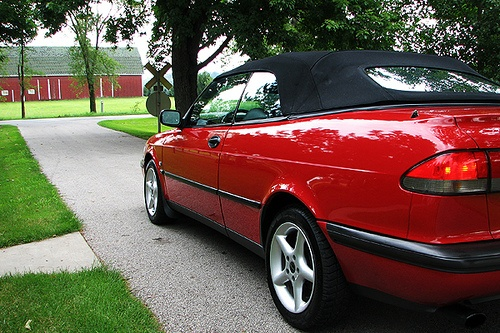

In [25]:
Image.open(os.path.join(img_folder, csv.iloc[0,0]))

Definimos una función auxiliar para visualizar las imágenes y las bboxes

In [26]:
cmap = matplotlib.colormaps['tab20']

In [27]:
str(cmap.colors[0])

'(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)'

In [28]:
def plot_image(image, boxes, classes=None, ax=None):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Si no hay un axes, lo creo y muestro la imagen
    if not ax:
        fig, ax = plt.subplots(1)
    ax.imshow(im)

    if classes:
        colors = [matplotlib.colormaps['tab20'].colors[c] for c in classes]

    # Dibujo la box 
    for i, box in enumerate(boxes):
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor=colors[i] if classes else 'r',
            facecolor="none",
        )
        # Agrego el rectanculo al dibujo
        ax.add_patch(rect)

        # Agrego texto:
        if classes:
            text = ax.text(
                x=upper_left_x*width,
                y=upper_left_y*height,
                s=class_labels[classes[i]],
                backgroundcolor=colors[i]
            )
    

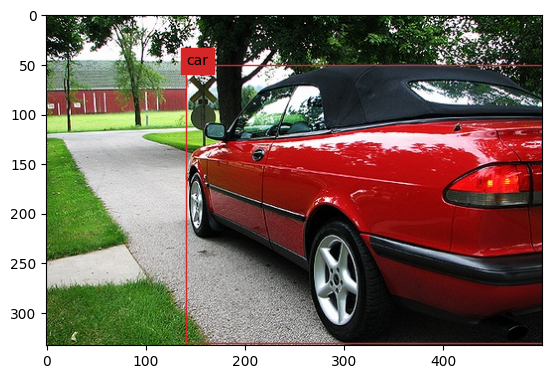

In [29]:
plot_image(Image.open(os.path.join(img_folder, csv.iloc[0,0])), read_bboxes(os.path.join(lbl_folder, csv.iloc[0,1])), classes=read_class(os.path.join(lbl_folder, csv.iloc[0,1])))

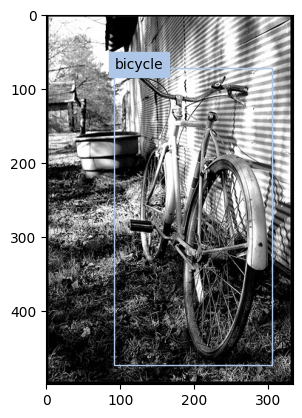

In [30]:
img_index = np.random.randint(len(csv))

plot_image(
    Image.open(os.path.join(img_folder, csv.iloc[img_index,0])),
    read_bboxes(os.path.join(lbl_folder, csv.iloc[img_index,1])),
    read_class(os.path.join(lbl_folder, csv.iloc[img_index,1]))
)

Vamos a crear una clase que hereda de `torch.utils.data.Dataset`, a la cual le tenemos que definir los métodos `__len__` y `__getitem__` para luego ser usados en el proceso de entrenamiento.
Luego podremos usar nuestro dataset custom para crear un DataLoader

In [31]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        """
        Función que calcula la cantidad de imágenes en el dataset
        """
        return len(self.annotations)

    def __getitem__(self, index):
        """
        Función que retorna la tupla (imagen, target) del index correspondiente
        """
        # Leemos el archivo con las etiquetas y extraemos las bboxes
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for line in f.readlines():
    
                line = line.replace("\n", "").split()
                class_label = int(line[0]) # Convierto la clase a un entero
                x, y, width, height = [float(c) for c in line[1:]] # Convierto las coordenadas a float

                boxes.append([class_label, x, y, width, height])
        boxes = torch.tensor(boxes)
        
        # Leemos la imagen
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        

        if self.transform:
            # Si hay que aplicar transformaciones a las imágenes, también hay que modificar las boxes
            image, boxes = self.transform(image, boxes)

        # Armo el volumen de salida

        # No necesita B bboxes ya que sólo existe una ground truth
        # label_matrix = torch.zeros((self.S, self.S, self.C + 5))
        # Por compatibilidad con una función que usaremos más adelante, 
        # le agregamos la 2nda bbox por más que quede vacía.
        
        # Inicializamos el volumen de salida en 0
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))

        # Iremos completando el volumen de salida con las boxes que leimos del archivo de texto
        for box in boxes:
            # Desempaqueto las coordenadas y etiqueta de clase
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # Calculo en qué celda se ubica el centro del objeto
            i = int(self.S * y) 
            j = int(self.S * x) 
            # Calculo las coordenadas del centro del objeto con respecto a la celda
            x_cell = self.S * x - j 
            y_cell = self.S * y - i 

            # Antes de asignar un objeto a la celda, debo verificar que la celda esté vacía
            if label_matrix[i, j, self.C] == 0:
                # Si no hay un objeto en la celda, lo ocupo
                label_matrix[i, j, self.C] = 1 # P(obj) = 1
                # Preparo el tensor con las coordenadas de la caja
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width, height]
                )
                # Agrego las coordenadas de la caja a la celda correspondiente (i, j)
                label_matrix[i, j, self.C+1:self.C+5] = box_coordinates
                # One-hot encoding de la clase
                label_matrix[i, j, class_label] = 1
        # Retorno la tupla
        return image, label_matrix

Hagamos una pequeña prueba de funcionamiento de la clase probando los dos métodos que tiene

In [32]:
# Instancio un objeto de nuestra clase
data = VOCDataset(
    csv_file="archive/8examples.csv", 
    img_dir=img_folder,
    label_dir=lbl_folder
)

In [33]:
len(data)

8

In [34]:
img, lbl = data.__getitem__(0)

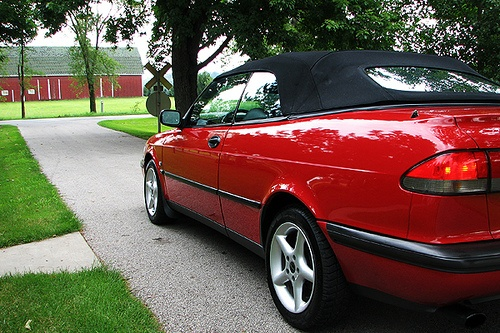

In [35]:
img

In [36]:
type(lbl), lbl.shape

(torch.Tensor, torch.Size([7, 7, 30]))

## Post-procesamiento
Dada la arquitectura del modelo, por cada pasada forward vamos a obtener 7x7x2 (SxSxB) bounding boxes, 2 para cada celda, de las cuales elegiremos las que mayor score de confianza tengan por celda. De las 49 bounding boxes restantes, nos quedaremos con las que sobrevivan al algoritmo non-maximum suppression.

### Non-maximum suppression

In [37]:
def non_max_suppression(
    bboxes: list,
    iou_threshold: float,
    conf_threshold: float
) -> list:
    """
    Implementación del algoritmo Non-maximum Suppression.

    bboxes: lista con bboxes, donde cada bbox = (class_idx, prob_score, x, y, w, h)
    iou_threshold: valor para asumir que 2 bboxes detectaron el mismo objeto
    conf_threshold: valor para descartar bboxes con baja confianza
    """

    # Descarto las bboxes con baja confianza
    bboxes = [bbox for bbox in bboxes if bbox[1] > conf_threshold]
    # Ordeno las bboxes de mayor a menor confianza
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    # Creo una lista para almacenar las bboxes que sobrevivan al descarte
    bboxes_post_nms = []

    # Itero hasta que no queden más bboxes 
    while len(bboxes) > 0:
        # Lista con índices de las bboxes que hay que descartar
        descartes = []

        # Elijo la bbox con más confianza y la saco de la lista
        best_box = bboxes.pop(0)
        # La agrego a la lista de sobrevivientes
        bboxes_post_nms.append(best_box)
        # La comparo con el resto de las bboxes
        for i, box in enumerate(bboxes):
            # Chequeo que pertenezca a la misma clase
            if box[0] == best_box[0]:
                # Si son de la misma clase, calculo IoU
                iou = intersection_over_union(
                    torch.tensor(box[2:]),
                    torch.tensor(best_box[2:])
                )
                # Chequeo si hay que descartarla o no
                if iou > iou_threshold:
                    descartes.append(i)
        
        # Actualizo la lista de bboxes descartando las que correspondan
        bboxes = [bbox for i, bbox in enumerate(bboxes) if i not in descartes]
    
    # Retorno las bboxes sobrevivientes
    return bboxes_post_nms

La función que acabamos de definir espera recibir un listado de bboxes con coordenadas relativas a toda la imagen, a diferencia del tensor que entrega el modelo que contiene coordenadas relativas a cada celda.

Deberemos:
- Descartar la bbox con menor confianza para cada celda
- Desnormalizar las coordenadas del centro de la bbox
- Decodificar la clase (one-hot -> int)

In [38]:
def post_process(preds, S=7, C=20, B=2):
    """
    Función que recibe las predicciones de YOLO y realiza su post procesamiento
    - Descarta la bbox con menor confianza para cada celda
    - Desnormaliza las coordenadas del centro de la box
    - Decodifica la clase
    - Extrae la confianza de la predicción del objeto Pr(object))
    """
    
    preds = preds.to('cpu')
    # Le damos forma de volumen a las predicciones
    preds = preds.reshape(-1, S, S, B*5+C)
    # Seleccionamos la bbox con mayor confianza
    bboxes1 = preds[..., C+1:C+5]
    bboxes2 = preds[..., C+6:C+10]
    scores = torch.cat(
        (preds[..., C].unsqueeze(0), preds[..., C+5].unsqueeze(0)),
        dim=0
    )
    best_box_idx = scores.argmax(0).unsqueeze(-1)
    best_boxes = (1 - best_box_idx) * bboxes1 + best_box_idx * bboxes2

    # Desnormalizamos las coordenadas del centro de cada bbox
    cell_indices_x = torch.arange(7).repeat(preds.shape[0], 7, 1).unsqueeze(-1)
    cell_indices_y = torch.arange(7).repeat(preds.shape[0], 7, 1).unsqueeze(-1).permute(0,2,1,3)
    x = 1 / S * (best_boxes[..., :1] + cell_indices_x)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices_y)
    wh = best_boxes[..., 2:4]
    # Armamos las coordenadas desnormalizadas
    boxes = torch.cat((x, y, wh), dim=-1)

    #Decodificamos la clase
    classes = preds[..., :C].argmax(-1).unsqueeze(-1)
    # Nos quedamos con el score de confianza de la box seleccionada
    confidences = torch.max(preds[..., C], preds[..., C+5]).unsqueeze(-1)

    # Unimos todas las partes
    preds_post = torch.cat(
        (classes, confidences, boxes), dim=-1
    )

    return preds_post   
    

Unifiquemos todo en una función que podamos aplicar a la salida del modelo para obtener los resultados finales de la predicción

In [39]:
def outputs_from_preds(preds, iou_threshold=0.5, conf_threshold=0.5, S=7, C=20, B=2):
    
    # Post procesamiento de predicciones
    preds = post_process(preds)
    # Convertimos tensor a lista
    preds = preds.reshape(-1, 7*7, 6)
    boxes = preds.tolist()
    # Aplicamos NMS a cada muestra del batch
    outputs = []
    for i in range(len(boxes)):
        post_nms = non_max_suppression(
            boxes[i], 
            iou_threshold=iou_threshold, 
            conf_threshold=conf_threshold
        )
        # print(f"Sólo quedaron {len(post_nms)} boxes de la imagen {i+1}")
        outputs.append(post_nms)
    return outputs

## Loop de entrenamiento

In [40]:
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision

Armamos una función para calcular el mAP utilizando la clase de `torchmetrics`

In [41]:
def compute_map(map, pred_boxes, true_boxes):
    preds_dict = []
    for boxes in pred_boxes:
        boxes_list = []
        scores_list = []
        labels_list = []
        for box in boxes:
            # Saco las coordenadas
            boxes_list.append(box[2:])
            # Saco el score
            scores_list.append(box[1])
            # Saco la clase
            labels_list.append(box[0])
        preds_dict.append({
            "boxes": torch.tensor(boxes_list),
            "scores": torch.tensor(scores_list),
            "labels": torch.tensor(labels_list)
        })
    true_dict = []
    for boxes in true_boxes:
        boxes_list = []
        scores_list = []
        labels_list = []
        for box in boxes:
            # Saco las coordenadas
            boxes_list.append(box[2:])
            # Saco el score
            scores_list.append(box[1])
            # Saco la clase
            labels_list.append(box[0])
        true_dict.append({
            "boxes": torch.tensor(boxes_list),
            "scores": torch.tensor(scores_list),
            "labels": torch.tensor(labels_list)
        })
    
    map.update(preds_dict, true_dict)
    mean_avg_prec = map.compute()
    
    return mean_avg_prec['map'].tolist()
    # return mean_avg_prec

Armamos una función para plotear el batch y las predicciones. Esto nos servirá para evaluar visualmente el progreso de las predicciones

In [42]:
def plot_batch(x, y_hat, ncols=4):
    nrows = int(np.ceil(x.shape[0] / ncols))
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16,8))
    x = x.to('cpu')
    for i in range(x.shape[0]):
        print()
        plot_image(
            image=x[i].permute(1,2,0),
            boxes=[out[2:] for out in y_hat[i]],
            classes=[int(out[0]) for out in y_hat[i]],
            ax=ax.flatten()[i]
        )
    return fig, ax

Definimos una clase para aplicar las transformaciones necesarias para el entrenamiento. Por cuestiones de tiempo y cómputo, sólo haremos un resizing de las imágenes, pero en la implementación original se utilizó data augmentation para prevenir overfitting ("_To avoid overfitting we use dropout and extensive data
augmentation._")

Investigar: https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

In [43]:
class Transformer: # NO CONFUNDIR CON VISION TRANSFORMERS!!
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

In [44]:
transform = Transformer([transforms.Resize((448, 448)), transforms.ToTensor(),])

Definimos una función para iterar por todo el dataset, correr inferencia, calcular la función de costo, calcular los gradientes y corregir los parámetros del modelo:

In [45]:
def train_fn(train_loader, model, optimizer, loss_fn):
    
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())
    mean_loss = sum(mean_loss)/len(mean_loss)
    return mean_loss

In [46]:
train_dataset = VOCDataset(
    csv_file="archive/8examples.csv", 
    img_dir=img_folder,
    label_dir=lbl_folder,
    transform=transform
)

In [47]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=8,
        shuffle=True
    )

In [48]:
len(train_dataset)

8

In [49]:
len(train_loader)

1

Instanciamos el modelo para entrenarlo

In [50]:
model = Yolov1(
    split_size=7, 
    num_boxes=2, 
    num_classes=20, 
    dropout=0, # Pongo dropout 0 porque el objetivo es overfitear
    fc_hidden_layer=512 # Ahico la hidden layer para que el modelo me entre en la GPU
) 
loss_fn = YoloLoss()

Instanciamos el optimizador

In [51]:
optimizer = optim.Adam(
        model.parameters(), lr=2e-5, weight_decay=0
    )

Preparamos el entrenamiento

In [52]:
# Verificamos is hay GPU disponible
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# Movemos los objetos al device que usaremos
model = model.to(DEVICE)
loss_fn = loss_fn.to(DEVICE)
# Definimos la cantidad de epochs por los que entrenaremos el modelo
EPOCHS = 100
# Instanciamos listas vacías para ir registrando el progreso del entrenamiento
global_losses = []
global_maps = []

Ahora deberemos llamar a la función de entrenamiento EPOCH veces.

Al final de cada epoch calcularemos mAP y lo usaremos como condición para early stopping

In [53]:
for epoch in range(EPOCHS):
    # Instanciamos listas vacías registrar el avance del entrenamiento en cada epoch
    losses = []
    maps = []
    print(f"Epoch {epoch+1}/{EPOCHS}")
    # Corremos un loop de entrenamiento por todo el dataset y calculamos la loss
    loss = train_fn(train_loader, model, optimizer, loss_fn)
    
    
    # Corremos una inferencia para todo el dataset y calculamos la mAP
    model.eval() # Ponemos las capas de BatchNorm y Dropout en modo evaluación
    map = MeanAveragePrecision(box_format='cxcywh', iou_thresholds=[0.5])
    for x, y in train_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        with torch.no_grad(): # No necesitamos los gradientes ya que no vamos a entrenar con estas predicciones
            preds = model(x)

        # Aplicamos post procesamiento a las predicciones y a los targets
        pred_boxes = outputs_from_preds(preds, conf_threshold=0.4)
        true_boxes = outputs_from_preds(y.reshape(y.shape[0], -1), conf_threshold=0.4) # Por esta función antes dejamos las 2ndas bboxes
    
        mean_avg_prec = compute_map(map, pred_boxes, true_boxes)    
        maps.append(mean_avg_prec)
        losses.append(loss)
        
    model.train()

    loss = sum(losses) / len(losses)
    global_losses.append(loss)
    mean_avg_prec = sum(maps) / len(maps)
    global_maps.append(mean_avg_prec)
    
    print(f"Train Loss: {loss} - Train mAP: {mean_avg_prec}")
    
    if mean_avg_prec > 0.99:
        break

Epoch 1/100


100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it, loss=235]


Train Loss: 234.9405517578125 - Train mAP: 0.0
Epoch 2/100


100%|███████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s, loss=168]


Train Loss: 168.40966796875 - Train mAP: 0.0
Epoch 3/100


100%|███████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s, loss=109]


Train Loss: 108.94964599609375 - Train mAP: 0.0
Epoch 4/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s, loss=44.2]


Train Loss: 44.163291931152344 - Train mAP: 0.0
Epoch 5/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s, loss=32.1]


Train Loss: 32.1435546875 - Train mAP: 0.0
Epoch 6/100


100%|████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s, loss=25]


Train Loss: 24.978958129882812 - Train mAP: 0.0
Epoch 7/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s, loss=19.8]


Train Loss: 19.79214859008789 - Train mAP: 0.0
Epoch 8/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s, loss=14.9]


Train Loss: 14.916996002197266 - Train mAP: 0.0
Epoch 9/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s, loss=11.9]


Train Loss: 11.868465423583984 - Train mAP: 0.0
Epoch 10/100


100%|███████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s, loss=9.8]


Train Loss: 9.799643516540527 - Train mAP: 0.0
Epoch 11/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s, loss=9.03]


Train Loss: 9.029674530029297 - Train mAP: 0.0
Epoch 12/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s, loss=9.64]


Train Loss: 9.639762878417969 - Train mAP: 0.0
Epoch 13/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s, loss=9.84]


Train Loss: 9.84365177154541 - Train mAP: 0.0
Epoch 14/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s, loss=8.66]


Train Loss: 8.66333293914795 - Train mAP: 0.0
Epoch 15/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s, loss=7.33]


Train Loss: 7.330928802490234 - Train mAP: 0.0
Epoch 16/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s, loss=5.97]


Train Loss: 5.974589824676514 - Train mAP: 0.0
Epoch 17/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s, loss=4.86]


Train Loss: 4.861668586730957 - Train mAP: 0.0
Epoch 18/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s, loss=4.22]


Train Loss: 4.215754508972168 - Train mAP: 0.0
Epoch 19/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s, loss=4.57]


Train Loss: 4.566684722900391 - Train mAP: 0.0
Epoch 20/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s, loss=5.06]


Train Loss: 5.061618328094482 - Train mAP: 0.0
Epoch 21/100


100%|███████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s, loss=5.7]


Train Loss: 5.70452880859375 - Train mAP: 0.0
Epoch 22/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s, loss=5.24]


Train Loss: 5.239171028137207 - Train mAP: 0.0
Epoch 23/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s, loss=4.53]


Train Loss: 4.5342535972595215 - Train mAP: 0.0
Epoch 24/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s, loss=3.66]


Train Loss: 3.658531904220581 - Train mAP: 0.0
Epoch 25/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s, loss=2.75]


Train Loss: 2.7492148876190186 - Train mAP: 0.0
Epoch 26/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s, loss=2.35]


Train Loss: 2.352795362472534 - Train mAP: 0.0
Epoch 27/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s, loss=3.32]


Train Loss: 3.3180489540100098 - Train mAP: 0.0
Epoch 28/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s, loss=2.56]


Train Loss: 2.562412738800049 - Train mAP: 0.0
Epoch 29/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s, loss=2.92]


Train Loss: 2.9234609603881836 - Train mAP: 0.0
Epoch 30/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s, loss=2.61]


Train Loss: 2.6050338745117188 - Train mAP: 0.0
Epoch 31/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s, loss=2.18]


Train Loss: 2.1832447052001953 - Train mAP: 0.0
Epoch 32/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s, loss=1.92]


Train Loss: 1.9165785312652588 - Train mAP: 0.0
Epoch 33/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s, loss=1.45]


Train Loss: 1.4460264444351196 - Train mAP: 0.0
Epoch 34/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s, loss=1.92]


Train Loss: 1.9154777526855469 - Train mAP: 0.056105609983205795
Epoch 35/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s, loss=9.49]


Train Loss: 9.494749069213867 - Train mAP: 0.056105609983205795
Epoch 36/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s, loss=14.2]


Train Loss: 14.199796676635742 - Train mAP: 0.056105609983205795
Epoch 37/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s, loss=12.6]


Train Loss: 12.635625839233398 - Train mAP: 0.056105609983205795
Epoch 38/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s, loss=11.1]


Train Loss: 11.121086120605469 - Train mAP: 0.056105609983205795
Epoch 39/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s, loss=8.71]


Train Loss: 8.7085599899292 - Train mAP: 0.056105609983205795
Epoch 40/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s, loss=6.45]


Train Loss: 6.451998710632324 - Train mAP: 0.056105609983205795
Epoch 41/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s, loss=4.97]


Train Loss: 4.9681291580200195 - Train mAP: 0.056105609983205795
Epoch 42/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s, loss=4.34]


Train Loss: 4.344393253326416 - Train mAP: 0.09471947699785233
Epoch 43/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s, loss=3.71]


Train Loss: 3.71466064453125 - Train mAP: 0.10737859457731247
Epoch 44/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s, loss=3.22]


Train Loss: 3.216769218444824 - Train mAP: 0.13902640342712402
Epoch 45/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s, loss=2.83]


Train Loss: 2.834246873855591 - Train mAP: 0.1666666716337204
Epoch 46/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s, loss=2.55]


Train Loss: 2.5545074939727783 - Train mAP: 0.1666666716337204
Epoch 47/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s, loss=2.28]


Train Loss: 2.280290126800537 - Train mAP: 0.1666666716337204
Epoch 48/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s, loss=2.04]


Train Loss: 2.039233922958374 - Train mAP: 0.1666666716337204
Epoch 49/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s, loss=1.84]


Train Loss: 1.8361936807632446 - Train mAP: 0.1666666716337204
Epoch 50/100


100%|███████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s, loss=1.6]


Train Loss: 1.598684310913086 - Train mAP: 0.1666666716337204
Epoch 51/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s, loss=1.38]


Train Loss: 1.378772258758545 - Train mAP: 0.1666666716337204
Epoch 52/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s, loss=1.19]


Train Loss: 1.1880489587783813 - Train mAP: 0.1666666716337204
Epoch 53/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s, loss=1.01]


Train Loss: 1.008865475654602 - Train mAP: 0.1666666716337204
Epoch 54/100


100%|█████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s, loss=0.861]


Train Loss: 0.8612785339355469 - Train mAP: 0.19141913950443268
Epoch 55/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s, loss=0.73]


Train Loss: 0.730430006980896 - Train mAP: 0.3580858111381531
Epoch 56/100


100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s, loss=0.621]


Train Loss: 0.6209319233894348 - Train mAP: 0.3580858111381531
Epoch 57/100


100%|█████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s, loss=0.546]


Train Loss: 0.5462689399719238 - Train mAP: 0.3580858111381531
Epoch 58/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s, loss=0.49]


Train Loss: 0.4902535676956177 - Train mAP: 0.44939491152763367
Epoch 59/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s, loss=0.44]


Train Loss: 0.43978410959243774 - Train mAP: 0.44939491152763367
Epoch 60/100


100%|█████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s, loss=0.397]


Train Loss: 0.3969390094280243 - Train mAP: 0.47070956230163574
Epoch 61/100


100%|█████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s, loss=0.361]


Train Loss: 0.3614344000816345 - Train mAP: 0.44939491152763367
Epoch 62/100


100%|█████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s, loss=0.324]


Train Loss: 0.32442495226860046 - Train mAP: 0.44939491152763367
Epoch 63/100


100%|█████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s, loss=0.292]


Train Loss: 0.2922475337982178 - Train mAP: 0.44939491152763367
Epoch 64/100


100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s, loss=0.261]


Train Loss: 0.26072537899017334 - Train mAP: 0.44939491152763367
Epoch 65/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s, loss=0.23]


Train Loss: 0.23000767827033997 - Train mAP: 0.632013201713562
Epoch 66/100


100%|█████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s, loss=0.206]


Train Loss: 0.2059839963912964 - Train mAP: 0.7283827662467957
Epoch 67/100


100%|█████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s, loss=0.183]


Train Loss: 0.18347592651844025 - Train mAP: 0.7528052926063538
Epoch 68/100


100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s, loss=0.158]


Train Loss: 0.15821680426597595 - Train mAP: 0.8305830359458923
Epoch 69/100


100%|██████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s, loss=0.14]


Train Loss: 0.14001241326332092 - Train mAP: 0.9150165915489197
Epoch 70/100


100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s, loss=0.124]


Train Loss: 0.12352878600358963 - Train mAP: 0.9207921624183655
Epoch 71/100


100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s, loss=0.108]


Train Loss: 0.10767162591218948 - Train mAP: 0.9651108384132385
Epoch 72/100


100%|████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s, loss=0.0979]


Train Loss: 0.09787693619728088 - Train mAP: 0.9651108384132385
Epoch 73/100


100%|████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s, loss=0.0888]


Train Loss: 0.08878831565380096 - Train mAP: 0.9384724497795105
Epoch 74/100


100%|████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s, loss=0.0782]


Train Loss: 0.07821168750524521 - Train mAP: 0.9651108384132385
Epoch 75/100


100%|████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s, loss=0.0728]

Train Loss: 0.07278124243021011 - Train mAP: 1.0


Ploteamos cómo evolucionó el modelo durante el entrenamiento

Text(0, 0.5, 'mAP')

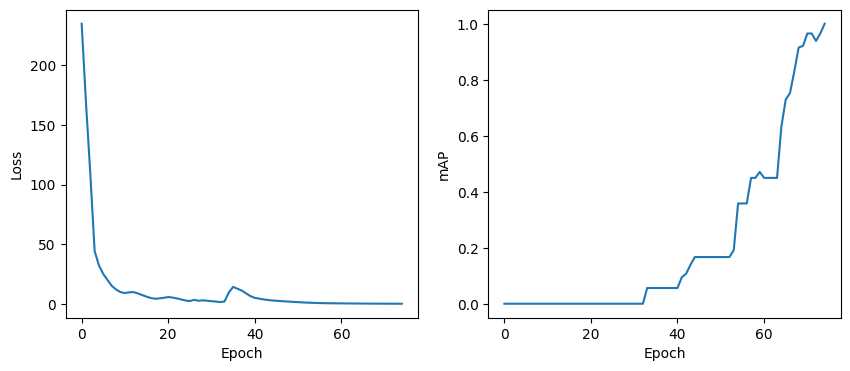

In [54]:
fix, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(list(range(len(global_losses))), global_losses)
ax[1].plot(list(range(len(global_losses))), global_maps);
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("mAP")

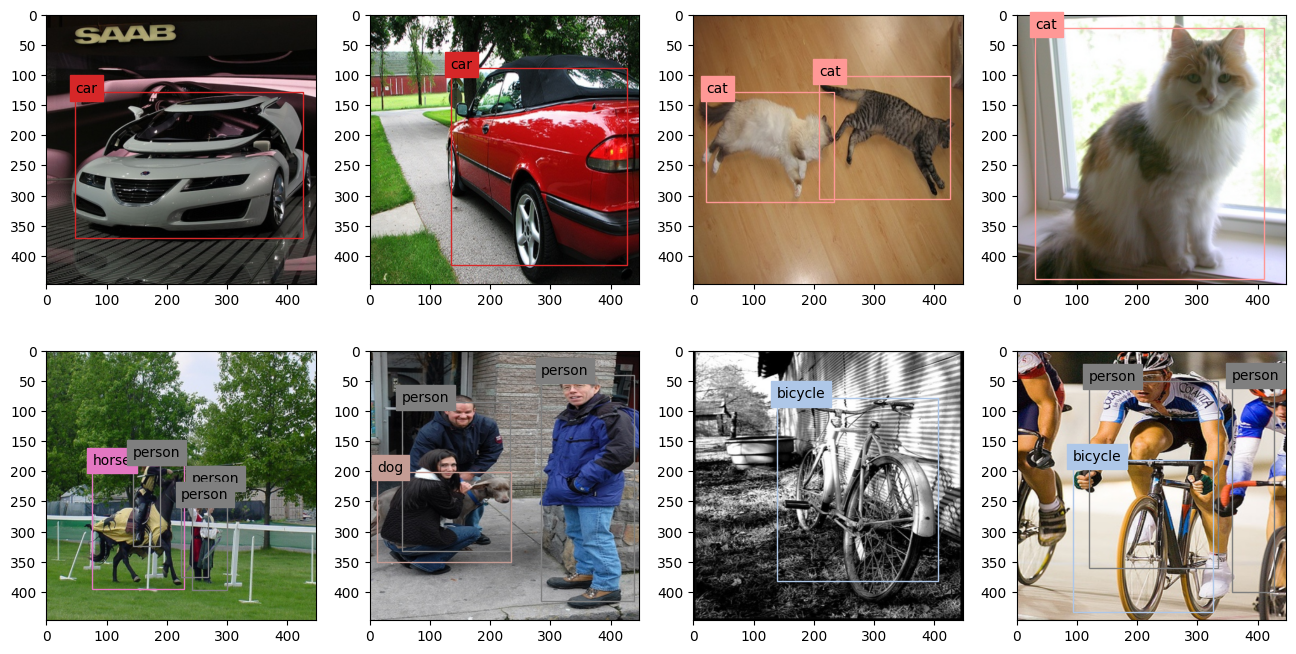

In [55]:
# Inspección visual del último batch
fig, ax = plot_batch(x, pred_boxes)

## Probamos con un dataset un poco más grande

In [56]:
train_dataset = VOCDataset(
    csv_file="archive/100examples.csv", 
    img_dir=img_folder,
    label_dir=lbl_folder,
    transform=transform
)

In [57]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=16,
        shuffle=True,
        drop_last=True
    )

In [58]:
len(train_dataset)

103

In [59]:
len(train_loader)

6

In [60]:
model = Yolov1(
    split_size=7, 
    num_boxes=2, 
    num_classes=20, 
    dropout=0, # Pongo dropout 0 porque el objetivo es overfitear
    fc_hidden_layer=512 # Ahico la hidden layer para que el modelo me entre en la GPU
) 
loss_fn = YoloLoss()

In [61]:
# Instancio el optimizador que usaremos para el entrenamiento
optimizer = optim.Adam(
        model.parameters(), lr=2e-5, weight_decay=0
    )

In [62]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(DEVICE)
loss_fn = loss_fn.to(DEVICE)
EPOCHS = 100
PLOT_EVERY_N_EPOCHS = 20
global_losses = []
global_maps = []

Epoch 1/100


100%|███████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s, loss=242]


Train Loss: 285.9037043253581 - Train mAP: 0.0
Epoch 2/100


100%|███████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s, loss=108]


Train Loss: 202.36052703857422 - Train mAP: 0.0
Epoch 3/100


100%|███████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s, loss=143]


Train Loss: 150.5888442993164 - Train mAP: 0.0
Epoch 4/100


100%|███████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s, loss=121]


Train Loss: 129.11651738484701 - Train mAP: 0.0
Epoch 5/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s, loss=59.9]


Train Loss: 107.78629938761394 - Train mAP: 0.0
Epoch 6/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s, loss=92.4]


Train Loss: 95.69345092773438 - Train mAP: 0.009997249658529958
Epoch 7/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s, loss=89.8]


Train Loss: 93.20219421386719 - Train mAP: 0.011068039884169897
Epoch 8/100


100%|███████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s, loss=139]


Train Loss: 101.45995457967122 - Train mAP: 0.018707248537490766
Epoch 9/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s, loss=83.5]


Train Loss: 91.82400767008464 - Train mAP: 0.04421520822991928
Epoch 10/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s, loss=70.2]


Train Loss: 85.3418795267741 - Train mAP: 0.09994108354051907
Epoch 11/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.56it/s, loss=97.9]


Train Loss: 75.48641904195149 - Train mAP: 0.18665799871087074
Epoch 12/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s, loss=44.5]


Train Loss: 67.5125192006429 - Train mAP: 0.3847425679365794
Epoch 13/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s, loss=36.1]


Train Loss: 67.31881523132324 - Train mAP: 0.494328906138738
Epoch 14/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s, loss=45.9]


Train Loss: 66.71250279744466 - Train mAP: 0.4487634350856145
Epoch 15/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.57it/s, loss=61.6]


Train Loss: 63.60101127624512 - Train mAP: 0.615117073059082
Epoch 16/100


100%|████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s, loss=50]


Train Loss: 59.02773412068685 - Train mAP: 0.6040660440921783
Epoch 17/100


100%|████████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s, loss=53]


Train Loss: 61.153510411580406 - Train mAP: 0.7000126242637634
Epoch 18/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s, loss=68.8]


Train Loss: 55.04249858856201 - Train mAP: 0.6195197403430939
Epoch 19/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s, loss=40.7]


Train Loss: 51.39071718851725 - Train mAP: 0.620665580034256
Epoch 20/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s, loss=44.1]


Train Loss: 49.56189282735189 - Train mAP: 0.6546278695265452
Epoch 21/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s, loss=45.6]


Train Loss: 48.78551165262858 - Train mAP: 0.6384397745132446
Epoch 22/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s, loss=49.7]


Train Loss: 47.392365137736 - Train mAP: 0.6448524792989095
Epoch 23/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.59it/s, loss=63.7]


Train Loss: 48.66601117451986 - Train mAP: 0.6741064389546713
Epoch 24/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s, loss=54.5]


Train Loss: 45.270720799764 - Train mAP: 0.5270240902900696
Epoch 25/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s, loss=58.8]


Train Loss: 51.68006261189779 - Train mAP: 0.6333059171835581
Epoch 26/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.61it/s, loss=44.2]


Train Loss: 50.93216069539388 - Train mAP: 0.7290100157260895
Epoch 27/100


100%|████████████████████████████████████| 6/6 [00:02<00:00,  2.57it/s, loss=30]


Train Loss: 49.29209232330322 - Train mAP: 0.7465973198413849
Epoch 28/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.56it/s, loss=29.7]


Train Loss: 45.72529951731364 - Train mAP: 0.7535681625207266
Epoch 29/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.58it/s, loss=53.4]


Train Loss: 42.66794522603353 - Train mAP: 0.788732091585795
Epoch 30/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s, loss=52.4]


Train Loss: 42.45922533671061 - Train mAP: 0.6932825744152069
Epoch 31/100


100%|████████████████████████████████████| 6/6 [00:02<00:00,  2.59it/s, loss=26]


Train Loss: 38.77504285176595 - Train mAP: 0.7672555843989054
Epoch 32/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s, loss=44.9]


Train Loss: 41.26675510406494 - Train mAP: 0.7310462792714437
Epoch 33/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s, loss=50.3]


Train Loss: 40.47171274820963 - Train mAP: 0.7120166520277659
Epoch 34/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s, loss=54.7]


Train Loss: 34.91374683380127 - Train mAP: 0.6267973581949869
Epoch 35/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.58it/s, loss=24.8]


Train Loss: 39.447115898132324 - Train mAP: 0.6751530865828196
Epoch 36/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.62it/s, loss=48.7]


Train Loss: 37.71794064839681 - Train mAP: 0.6432065566380819
Epoch 37/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s, loss=33.1]


Train Loss: 35.05709902445475 - Train mAP: 0.6995054880777994
Epoch 38/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.59it/s, loss=25.1]


Train Loss: 37.897087732950844 - Train mAP: 0.703014463186264
Epoch 39/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.57it/s, loss=49.8]


Train Loss: 37.398305575052895 - Train mAP: 0.7196436325709025
Epoch 40/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.56it/s, loss=23.5]


Train Loss: 34.47151247660319 - Train mAP: 0.7555017471313477
Epoch 41/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s, loss=42.9]


Train Loss: 37.51500956217448 - Train mAP: 0.712834378083547
Epoch 42/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.56it/s, loss=39.5]


Train Loss: 29.201507886250813 - Train mAP: 0.6836924254894257
Epoch 43/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.57it/s, loss=42.3]


Train Loss: 33.20471954345703 - Train mAP: 0.7084086934725443
Epoch 44/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.59it/s, loss=59.7]


Train Loss: 38.20866298675537 - Train mAP: 0.7529952029387156
Epoch 45/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s, loss=29.9]


Train Loss: 33.03192933400472 - Train mAP: 0.7758901715278625
Epoch 46/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s, loss=14.8]


Train Loss: 33.1779457728068 - Train mAP: 0.7463444670041403
Epoch 47/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s, loss=39.5]


Train Loss: 36.84359486897787 - Train mAP: 0.5425122479597727
Epoch 48/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s, loss=43.1]


Train Loss: 41.876954078674316 - Train mAP: 0.723422239224116
Epoch 49/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.29it/s, loss=28.7]


Train Loss: 38.42624696095785 - Train mAP: 0.6508497397104899
Epoch 50/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.56it/s, loss=31.1]


Train Loss: 33.402502377827965 - Train mAP: 0.6376714905103048
Epoch 51/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s, loss=16.6]


Train Loss: 32.15767319997152 - Train mAP: 0.7801981270313263
Epoch 52/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s, loss=29.3]


Train Loss: 33.298495610555015 - Train mAP: 0.6760557591915131
Epoch 53/100


100%|██████████████████████████████████| 6/6 [00:02<00:00,  2.44it/s, loss=18.9]


Train Loss: 32.02393658955892 - Train mAP: 0.8496714532375336


















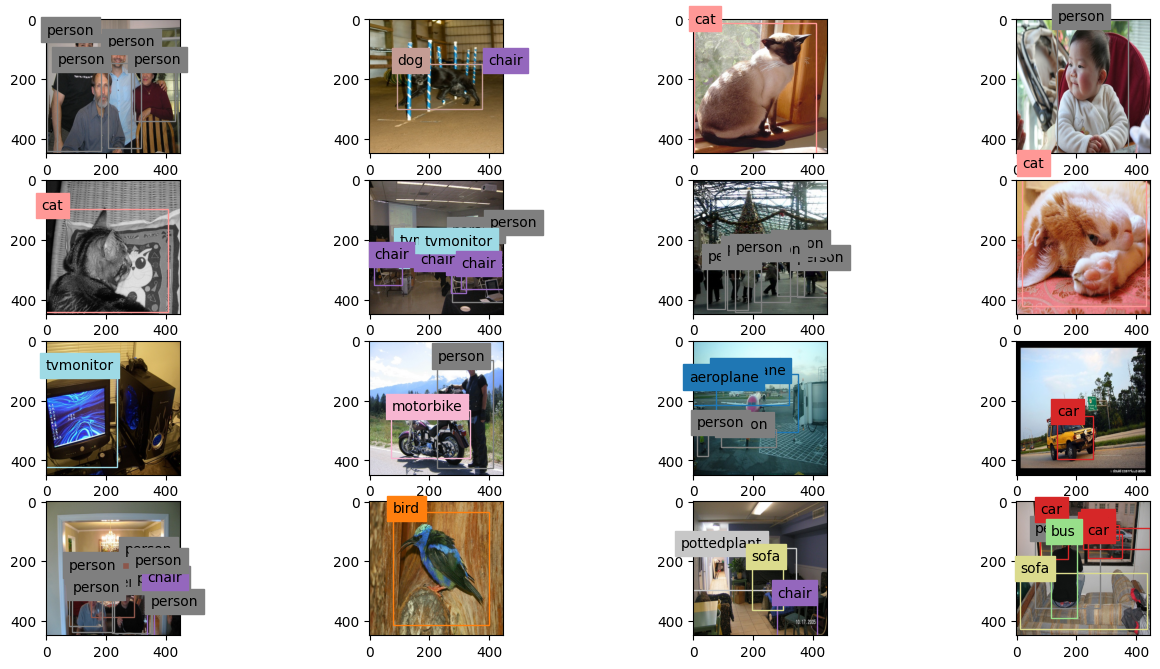

In [63]:
for epoch in range(EPOCHS):
    losses = []
    maps = []
    print(f"Epoch {epoch+1}/{EPOCHS}")
    loss = train_fn(train_loader, model, optimizer, loss_fn)
    map = MeanAveragePrecision(box_format='cxcywh', iou_thresholds=[0.5])

    # Corremos una inferencia para cada imagen del batch
    model.eval() # Ponemos las capas de BatchNorm y Dropout en modo evaluación
    for x, y in train_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        with torch.no_grad(): # No necesitamos los gradientes ya que no vamos a entrenar con estas predicciones
            preds = model(x)
        
        pred_boxes = outputs_from_preds(preds, conf_threshold=0.4)
        true_boxes = outputs_from_preds(y.reshape(y.shape[0], -1), conf_threshold=0.4) # Por esta función antes dejamos las 2ndas bboxes
    
        mean_avg_prec = compute_map(map, pred_boxes, true_boxes)    
        maps.append(mean_avg_prec)
        losses.append(loss)
        
    model.train()

    loss = sum(losses) / len(losses)
    global_losses.append(loss)
    mean_avg_prec = sum(maps) / len(maps)
    global_maps.append(mean_avg_prec)
    
    print(f"Train Loss: {loss} - Train mAP: {mean_avg_prec}")
    
    if mean_avg_prec > 0.8:
        fig, ax = plot_batch(x, pred_boxes)
        break

    # if epoch % PLOT_EVERY_N_EPOCHS == 0:
    #     fig, ax = plot_batch(x, pred_boxes)
    #     fig.savefig(f"epoch_{epoch}-map_{mean_avg_prec:.3f}.png")

Ploteamos cómo evolucionó el modelo durante el entrenamiento

Text(0, 0.5, 'mAP')

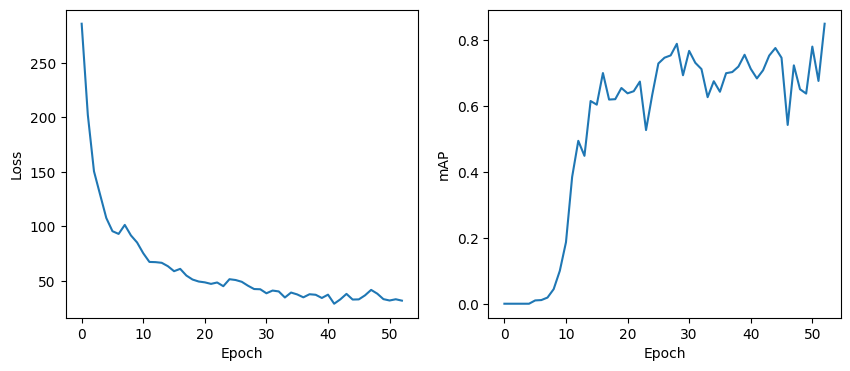

In [64]:
fix, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(list(range(len(global_losses))), global_losses)
ax[1].plot(list(range(len(global_losses))), global_maps);
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("mAP")

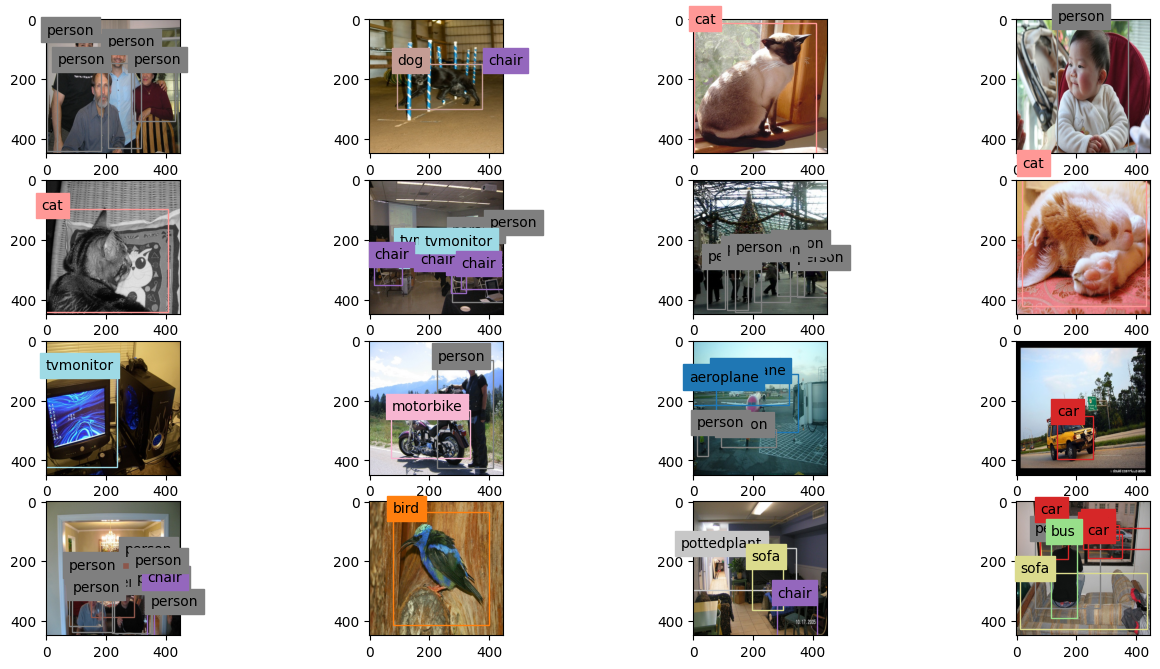

In [65]:
# Inspección visual del último batch
fig, ax = plot_batch(x, pred_boxes)